# MODIS Monthly Snow Preprocessing Pipeline & ARD Analytics Using Dask

The following Workflow using GEOAnalytics Canada's JupyterHub, Container Registry, Pipeline, and Dask Cluster systems to collect, preprocess, and then analyse data to produce informative ARD Snow Cover products that can then be used by professionals to assess snow accumulation, potential runoff threats, potential avalanche threats, etc.

Monthly median composites using [MODIS Snow Cover Daily (modis-10A1-061) product, a Level-3 product produced by NASA](https://nsidc.org/sites/default/files/mod10a1-v061-userguide_1.pdf) over Quebec, Canada for the winter seasons starting 2009/2010 until 2020/2021. 

From the User Guide:
>Snow-covered land typically has very high reflectance in visible bands and very low reflectance in
shortwave infrared bands. The Normalized Difference Snow Index (NDSI) reveals the magnitude of
this difference. The snow cover algorithm calculates NDSI for all land and inland water pixels in
daylight using Terra MODIS band 4 (visible green) and band 6 (shortwave near-infrared).

Covering 10 years (five winter seasons), collecting daily data over the area of an entire province, although MODIS is a lower spatially resolute sensor at 500m/pixel, still accumulates a signifigant throughput of data quantity. Something a single computer, which has typically been used in similar approaches in industry, would take a long time. 

Gathering and preprocessing data can be easily automated using GEOAnalytics' Pipeline system. By horizontally scaling our gathering and preprocessing, we can greatly reduce the time it takes to get informative and usable data - this even includes multiple iterations for tweaks, if necessary. Using certain compute resources and placing those resources next to the data, this also has implications for reducing cost. 

> **Note**
> GEOAnalytics CR portal for members of Earth Obervation for Public Health is found at: https://registry.eo4ph.geoanalytics.ca

We will use Quebec's boundary defined by [Canada's Open Data Provincial Administrative Boudnaries](https://open.canada.ca/data/en/dataset/306e5004-534b-4110-9feb-58e3a5c3fd97/resource/15ea678b-8667-43ce-b80c-6545e039ee00) to drill down on just this Province's snow cover.

> **Note**
> It is easy to adapt this workflow for other Provinces or AOI's by providing the appropriate WKT Shape. 

Using this AOI to determine data intersections, we preprocess accordingly to a minimal ARD output, preserving valid
data values, and saving out to Cloud Storage to be used in subsequent analytics. As an example of how ARD data can be used, this documentation finishs off by collecting another shapefile from Canada's Open Data Portal - the [National Hydrometric Network Index](https://open.canada.ca/data/en/dataset/a4b190fe-e090-4e6d-881e-b87956c07977/resource/982a89a4-10d4-44b4-b0f5-687394472e93) - and showing how it's possible to create more refined data over water basins that compose the Lower Arnaud basin. 

Each Task in the Pipeline system uses a custom Docker Image, built in the following section, and then pushed to [GEOAnalytics Container Registry](https://docs.geoanalytics.ca/1_getting_started/08-container-registry.html) (CR).

GEOAnalytics Canada Pipelines leverages Argo Workflows as the underlying workflow manager and we recommend using Python Hera framework to declare the components, as shown below.

The Pipeline portion of this code relies on the following core package versions:

```bash
hera==5.5.1
xarray==2023.7.0
rioxarray==0.15.0
pystac_client==0.7.2
planetary-computer==1.0.0
```

In [1]:
# Global Configuration
# --------------------
registry_url = 'registry.eo4ph.geoanalytics.ca'
repository = 'tutorial'
image_version_tag = '0.1.1'
docker_image_tag = f'{registry_url}/{repository}/snow-cover:{image_version_tag}'

## Create Custom Container Image From Dockerfile

To be able to execute the methods we will be implementing below, we will create a simple and custom minimal environment necessary for our functions to run in.
In this documentation, we use Python's Docker framework to build our Image, log in to [GEOAnalytics Container Registry](https://docs.geoanalytics.ca/1_getting_started/08-container-registry.html) (CR), and finally push our Image to be used in our Pipeline Workflow. 
The Image is built using the Docker in Docker (DinD) sidecar, accessible over localhost and preconfigured for the JupyterHub session to use. 

The Pipeline system is capable of pulling Images from GEOAnalytics CR.

The same effect can be accomplished via an external Dockerfile and using the Docker CLI commands.

In [ ]:
! pip install --user docker==6.1.3

In [ ]:
# Section Imports
# ---------------
import os
import io
import getpass
import docker

In [ ]:
# DinD (Docker in Docker) sidecar is accessible over localhost
docker_client = docker.from_env()

The following code shows a String representation of a Dockerfile which can be turned into a Pythonic file-like object, which the Python Docker framework `build()` method accepts. 
Alternatively, if keeping such things in memory is not necessary, a file path on the filesystem can be used to point at a Dockerfile. 

In [ ]:
dockerfile = """
FROM python:3.11-slim
RUN apt update --no-install-recommends \
    >>/dev/null
    
RUN pip install \
        pandas==2.0.3 \
        geopandas==0.13.2 \
        numpy==1.24.4 \
        pystac==1.8.3 \
        pystac_client==0.7.2 \
        planetary-computer==1.0.0 \
        odc-stac==0.3.6 \
        azure-storage-blob==12.17.0 \
        xarray==2023.7.0 \
        rioxarray==0.15.0 \
        pyproj==3.6.0 \
        shapely==2.0.1 \
        Pillow==10.0.0
"""
dockerfile_file = io.BytesIO(dockerfile.encode())

In [ ]:
dockerfile_file.name = 'dockerfile'

In [ ]:
docker_client.images.build(fileobj=dockerfile_file, tag=docker_image_tag)

Log in to GEOAnalytics CR using your username (inferred from environment variable) and password. 
You will need to log in in order to 1. verify that you are a authenticated User and 2. be able to push to your public and private repositories. 

In [ ]:
docker_client.login(
    username=os.getenv('JUPYTERHUB_USER'),
    password=getpass.getpass(),
    registry=registry_url
)

Finally, push your new custom Image to the CR. 

In [ ]:
docker_client.images.push(docker_image_tag)

## Pipeline Workflow

This section decalares the components used in the preprocessing workflow

In [100]:
# Import the required libraries
import io
import os
import yaml
import zipfile
import requests

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

from glob import glob
from shapely.geometry import Polygon, MultiPolygon
from typing import List, Dict, Tuple, Any

from hera.shared import global_config
from hera.workflows import (
                        Artifact, 
                        Workflow, 
                        script, 
                        DAG, 
                        Resources, 
                        Parameter, 
                        Env,
                        RetryStrategy,
                        WorkflowTemplate,
                        models as m,
)

Set the Global configuration for Argo Workflows - the underlying system for GEOAnalytics Canada Pipelines. 

In [3]:
global_config.api_version = "argoproj.io/v1"
global_config.host = os.getenv("WORKFLOW_HOST")

GEOAnalytics Canada offers a variety of Node types to provision workloads on to. To determine what is available, contact the Admin group. 

In [4]:
user_config = None
with open(f'/home/jovyan/geoanalytics_{os.getenv("JUPYTERHUB_USER")}/userConfig.yaml', 'r') as f:
    user_config = yaml.safe_load(f)

In [5]:
pipeline_node_config = user_config['pipeline']['node-config']

Using the configuration set by the User at the main workflow's entrypoint, we generate a "payload" for subsequent Tasks which will allow the desired set of data to be gathered and processed. 

This Task can also be configured in a [CRON Workflow](https://argoproj.github.io/argo-workflows/cron-workflows/) (a Workflow that executes on a specific schedule) ([Hera implementation](https://hera-workflows.readthedocs.io/en/latest/examples/workflows/upstream/cron_workflow/?h=cron)) where the `years` and `months` arguments may be `None` and therefore default to the current year and month, as defined by the functions code.
Then a CRON schedule for the beginning of the month (given a few days for L3 data to be processed and uploaded) can be set to ingest data of interest automatically. 

In [79]:
@script(
    image=docker_image_tag,
    resources=Resources(cpu_request='100m', memory_request='128Mi'),
    node_selector=pipeline_node_config['small']['nodeSelector'],
    tolerations=pipeline_node_config['small']['tolerations']
)
def fan_out_temporal_range(
        catalog_url: str,
        collection: str,
        assets: List[str],
        years: List[int] | None, # Will default to current year
        months: List[int] | None, # Will default to current month 
        target_province: str,
        output_prefix: str = '',
    ):
    """

    """
    import sys
    import json
    from datetime import datetime

    if not isinstance(years, list):
        years = [years]

    if not isinstance(months, list):
        month = [months]
        
    if years is not None:
        for year in years:
            if int(year) < 2000:
                raise ValueError(f'MODIS collection starts at 02/24/2000: Error {start_year}')
            elif int(year) > int(datetime.now().strftime('%Y')) and month > int(datetime.now().strftime('%m')):
                raise ValueError(f'Cannot query future: Error {end_year}')
            else:
                pass
    else:
        years = [int(datetime.now().strftime('%Y'))]

    if months is not None:
        for month in months:
            if int(month) < 1 or month > 12:
                raise ValueError(f'Month range is from 1 to 12, inclusive: Error: {start_month}')
    else:
        months = [int(datetime.now().strftime('%m'))]
        
    temporal_range = []
    for year in years:
        for month in months:
            if month < 10:
                month = f'0{month}'

            payload = {
                'catalog_url': catalog_url,
                'collection': collection,
                'assets': assets,
                'year': year,
                'month': month,
                'output_prefix': output_prefix
            }
            temporal_range.append(payload)
    json.dump(temporal_range, sys.stdout)
    

Using the temporal range list and the AOI Artifact, we can parallelise querying for available data from [Planetary Computer's STAC server](https://planetarycomputer.microsoft.com/dataset/modis-10A1-061#overview).
MODIS Snow Cover Daily, as the name suggests, is a daily product. 
However, as can be seen in the following Task, the dates gathered by the initial query are converted into a new "payload" for the next Task. 
This implements some resiliency to missing dates or when targetting a non-daily product in order to successfully gather data.

In [7]:
@script(
    image=docker_image_tag,
    resources=Resources(cpu_request='500m', memory_request="3Gi"),
    node_selector=pipeline_node_config['small']['nodeSelector'],
    tolerations=pipeline_node_config['small']['tolerations'],
    inputs=[
        Parameter(name='aoi'),
        Parameter(name='payload')
    ],
    
)
def query_for_data(aoi: str, payload: Dict[str, Any]):
    """

    """
    import os
    import sys
    import json
    import shapely.wkt
    import pystac_client
    import planetary_computer

    os.environ['USE_PYGEOS'] = '0'
    import geopandas as gpd
    
    from pathlib import Path
    from datetime import datetime

    try:
        os.makedirs('/tmp/payloads')
    except:
        pass

    payload
    geom = shapely.wkt.loads(aoi)

    catalog = pystac_client.Client.open(
        payload['catalog_url']
    )

    query_time_range = f"{payload['year']}-{payload['month']}"
    query = catalog.search(
        collections=payload['collection'],
        intersects=geom.envelope,
        datetime=query_time_range
    )

    date_track_list = []
    item_payloads = []
    for item in query.items_as_dicts():
        target_date = datetime.strftime(
            datetime.strptime(
                item['properties']['start_datetime'], 
                '%Y-%m-%dT%H:%M:%SZ'
            ), '%Y-%m-%d')
        if target_date not in date_track_list:
            date_track_list.append(target_date)
            item_payload = {}
            item_payload['query-date'] = target_date
            item_payload.update(payload)
            item_payloads.append(item_payload)
    
    json.dump(item_payloads, sys.stdout)



The following Task is the engine of the preprocessing - the data is pulled and operated on. 
As networks can be susceptible to down-time, a `RetryStrategy` is implemented in order to attempt again in case of a failed communication. 
If the request fails up to the limit, then this and subsequent Tasks will also fail. 
The AOI Artifact retrieved at the beginning of the Workflow is now used not just to query but also to clip the retrieved data. 
This minimises unwanted data being stored and further processed - avoiding wasting compute on what would be discarded otherwise. 
Each Task will receive a list of payloads targetting the temporal window defined in the previous step (a month in this specific case). 
Once preprocessed, the data is saved to Cloud storage and the path to that data is delivered to the next Task. 

In [8]:
@script(
    image=docker_image_tag,
    resources=Resources(cpu_request='2000m', memory_request="16Gi"),
    node_selector=pipeline_node_config['medium']['nodeSelector'],
    tolerations=pipeline_node_config['medium']['tolerations'],
    retry_strategy=RetryStrategy(
            limit=10,
            backoff=m.Backoff(
                duration="30",
                factor="2",
                max_duration="5m",
            )
    ),
    inputs=[
        Parameter(name='aoi'),
        Parameter(name='payload')
    ],
)
def process_image_tiles(aoi: str, payload: str):
    """

    """
    import io
    import os
    import sys
    import json
    import xarray
    import pyproj
    import odc.stac
    import rioxarray
    import shapely.wkt
    import pystac_client
    import planetary_computer
    
    import numpy as np
    os.environ['USE_PYGEOS'] = '0'
    import geopandas as gpd
    import numpy as np
    
    from pathlib import Path
    from shapely.ops import transform
    from rioxarray.merge import merge_arrays
    from azure.storage.blob import ContainerClient

    container_client = ContainerClient(
            os.getenv('AZURE_STORAGE_CONTAINER_URL'),
            container_name=os.getenv('AZURE_STORAGE_CONTAINER_NAME'),
            credential=os.getenv('AZURE_STORAGE_CONTAINER_TOK'),
        )

    geom = shapely.wkt.loads(aoi)
    
    query_time_range = payload['query-date']

    catalog = pystac_client.Client.open(
        payload['catalog_url'],
        modifier=planetary_computer.sign_inplace
    )

    query = catalog.search(
        collections=payload['collection'],
        intersects=geom.envelope,
        datetime=query_time_range
    )

    modis_granules = []
    for item in query.items():
        data_crs = 3978
        data = odc.stac.load(
            [item],
            bands=payload['assets'],
            crs=data_crs
        )
        if isinstance(data, xarray.Dataset):
            asset = payload['assets'][0]
            data = data.to_array(dim=asset, name=asset)
        
        # Remove all dimensions of one
        data = data.squeeze()

        # Preprocess to omit unwanted values
        filtered_data = xarray.where(((data == 0)|(data > 100)), np.nan, data, keep_attrs=True)
        filtered_data.rio.set_nodata(np.nan, inplace=True)
        filtered_data.rio.write_crs(data_crs, inplace=True)
        modis_granules.append(filtered_data)

    # Merge all granules into our AOI
    merged_data = merge_arrays(
        modis_granules,
        # bounds=geom.bounds,
        nodata=np.nan
    )
    
    # Clip data to reduce size and isolate to AOI
    clipped_data = merged_data.rio.clip(
                            [geom],
                            crs=4326, # input geometry CRS - not data CRS
                            all_touched=True,
                            drop=True
                        )
    
    # Write Raster
    filename = f'{asset}-{query_time_range}.tif'
    output_path = (Path(payload['output_prefix']) /  
                   Path(query_time_range) /
                   Path(filename)
                   ).as_posix()
    
    
    blob_client = container_client.get_blob_client(output_path)

    with io.BytesIO() as buf:
        clipped_data.rio.to_raster(buf, driver='GTiff')
        buf.seek(0)
        blob_client.upload_blob(buf, overwrite=True)
    json.dump(output_path, sys.stdout)


## Main Workflow Entrypoint

The main entrypoint to the Workflow 

The first tasks we need to implement are those to gather the prerequisite AOI file and to declare our other input parameters. 

The AOI file is hosted as a zipped up Shapefile. From [Canada's Open Data Portal](https://open.canada.ca/en), we can use Python's `requests` library to `GET` the [data](https://open.canada.ca/data/en/dataset/306e5004-534b-4110-9feb-58e3a5c3fd97/resource/15ea678b-8667-43ce-b80c-6545e039ee00). 
However, shapefiles are difficult to use when not on a local filesystem - so we will load this from local and deliver a MultiPolygon, created from the target geometry, into the workflow as an argument. 

In [9]:
def generate_polygon(
        url: str,
        target_province: str
    ) -> MultiPolygon:
    """

    """
    try:
        os.makedirs('/tmp/canvec')
    except FileExistsError:
        pass
    
    res = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(res.content), 'r') as zf:
        zf.extractall(path='/tmp/canvec')

    shp_file = glob('/tmp/canvec/**/*geo_pol*_2.shp')[0]
    gdf = gpd.read_file(shp_file)

    # Pull out Adminitrative Boundary to usable Shape
    tgt_col = 'juri_en'
    aoi_all = gdf[gdf[tgt_col] == target_province]
    mp = MultiPolygon([poly for poly in aoi_all.geometry.values.tolist() if isinstance(poly, Polygon)])
    return mp

In [10]:
# Convenience list of Canadian Provinces in a left-to-right then up and back order
target_provinces = [
    'British Columbia',               # 0
    'Alberta',                        # 1
    'Saskatchewan',                   # 2
    'Manitoba',                       # 3
    'Ontario',                        # 4
    'Quebec',                         # 5
    'New Brunswick',                  # 6
    'Nova Scotia',                    # 7
    'Prince Edward Island',           # 8
    'Newfoundland and Labrador',      # 9
    'Nunavut',                        # 10
    'Northwest Territories',          # 11
    'Yukon'                           # 12
]

In [13]:
# Workflow Configuration Section
# -------------------------------

# URL containing the Canadian Provincial Administrative boundary shapes.
canada_boundaries_endpoint = 'https://ftp.maps.canada.ca/pub/nrcan_rncan/vector/canvec/shp/Admin/canvec_15M_CA_Admin_shp.zip'

# The Province name is used as an identifier into Storage
# as well as retrieving the correct geometry from our shapefile
aoi_list_idx = 5
target_province = target_provinces[aoi_list_idx]
prov_pth_piece = target_province.replace(' ', '').strip().lower()

# Planetary Computer STAC Configuration
catalog_url = 'https://planetarycomputer.microsoft.com/api/stac/v1'
collection = 'modis-10A1-061'
assets = ['NDSI_Snow_Cover']
container_folder_prefix = f'modis/{target_province}/daily-snow'

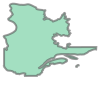

In [41]:
aoi = generate_polygon(canada_boundaries_endpoint, target_province)
aoi

In [80]:
def generate_name_with_time(_years: str, _months: str) -> str:
    _months = [int(month) for month in _months]
    min_year = f'{min(_years)}'
    max_year = f'{max(_years)}'
    min_month = f'{min(_months)}' if min(_months) < 10 else f'0{min(_months)}'
    max_month = f'{max(_months)}' if max(_months) < 10 else f'0{max(_months)}'
    return f'{min_year}{min_month}-{max_year}{max_month}'

In [94]:
with Workflow(
    name=f"ingest-{collection.lower()}",
    namespace=os.getenv("WORKFLOW_NS"),
    entrypoint="data-pipe",
    parallelism=50,
    arguments=[
            Parameter(name='catalog_url'),
            Parameter(name='collection'),
            Parameter(name='assets'),                               
            Parameter(name='years'),
            Parameter(name='months'),
            Parameter(name='target_province'),
            Parameter(name='output_prefix'),
            Parameter(name='aoi'),   
    ]
) as wf:

    with DAG(
        name='ingest',
        parallelism=10,
        inputs=[
            Parameter(name='aoi'),
            Parameter(name='payload')
        ]
    ) as ingest_dag:
        a2 = process_image_tiles(
            arguments={
                'aoi': '{{workflow.parameters.aoi}}',
                'payload': '{{inputs.parameters.payload}}'
            },
        )

        a2
        # Include additional preprocessing Tasks 
        # by joining them into the DAG: a2 >> ...

    with DAG(
        name='fanout',
        parallelism=30,
        inputs=[
            Parameter(name='aoi'),
            Parameter(name='payload')
        ]
    ) as fanout_dag:
        
        a1 = query_for_data(
            arguments={
                'aoi': '{{workflow.parameters.aoi}}',
                'payload': '{{inputs.parameters.payload}}'
            },
        )
        proc = ingest_dag(
                    name='ingest-data',
                    arguments={
                        'aoi': '{{inputs.parameters.aoi}}',
                        'payload': '{{item}}'
                    },
                    with_param = a1.result
        )
        a1 >> proc
    
    with DAG(
        name='data-pipe', 
        parallelism=10,
    ) as _d:
        a0 = fan_out_temporal_range(
                inputs=[
                    wf.get_parameter('aoi').with_name('aoi')
                ],
                arguments={
                        'catalog_url': '{{workflow.parameters.catalog_url}}',
                        'collection': '{{workflow.parameters.collection}}',
                        'assets': '{{workflow.parameters.assets}}',                               
                        'years': '{{workflow.parameters.years}}',
                        'months': '{{workflow.parameters.months}}',
                        'target_province': '{{workflow.parameters.target_province}}',
                        'output_prefix': '{{workflow.parameters.output_prefix}}'
                    }
            )

        fan_out = fanout_dag(
            name='fanout',
            arguments={
                'aoi': wf.get_parameter('aoi'),
                'payload': '{{item}}'
            },
            with_param=a0.result
        )

        a0 >> fan_out
        

In [95]:
wft = WorkflowTemplate().from_dict(wf.to_dict())
wft.update();
# wft.create();

To retrieve the desired data over our AOI and time range of interest, we can split the temporal input parameters into logical pieces that the workflow understands. Doing this avoids collecting and processing data that will not be subsequently used. 

In [96]:
# Front range
years = [2009]
months = [10, 11, 12]

w = Workflow(
    name=f"ingest-{collection.lower()}-{prov_pth_piece}-{generate_name_with_time(years, months)}",
    workflow_template_ref=wft,
    namespace=os.getenv("WORKFLOW_NS"),
    entrypoint="data-pipe",
    parallelism=50,
    arguments=[
        Parameter(name='catalog_url', value=catalog_url),
        Parameter(name='collection', value=collection),
        Parameter(name='assets', value=assets),
        Parameter(name='years', value=years),
        Parameter(name='months', value=months),
        Parameter(name='target_province', value=target_province),
        Parameter(name='output_prefix', value=container_folder_prefix),
        Parameter(name='aoi', value=aoi.wkt)
]
)

w.create();

In [97]:
# Middle range
years = [yr for yr in range(2010, 2015, 1)]
months = [10, 11, 12, 1, 2, 3, 4]

w = Workflow(
    name=f"ingest-{collection.lower()}-{prov_pth_piece}-{generate_name_with_time(years, months)}",
    workflow_template_ref=wft,
    namespace=os.getenv("WORKFLOW_NS"),
    entrypoint="data-pipe",
    parallelism=50,
    arguments=[
        Parameter(name='catalog_url', value=catalog_url),
        Parameter(name='collection', value=collection),
        Parameter(name='assets', value=assets),
        Parameter(name='years', value=years),
        Parameter(name='months', value=months),
        Parameter(name='target_province', value=target_province),
        Parameter(name='output_prefix', value=container_folder_prefix),
        Parameter(name='aoi', value=aoi.wkt)
]
)

w.create();

In [98]:
# Middle range
years = [yr for yr in range(2016, 2020, 1)]
months = [10, 11, 12, 1, 2, 3, 4]

w = Workflow(
    name=f"ingest-{collection.lower()}-{prov_pth_piece}-{generate_name_with_time(years, months)}",
    workflow_template_ref=wft,
    namespace=os.getenv("WORKFLOW_NS"),
    entrypoint="data-pipe",
    parallelism=50,
    arguments=[
        Parameter(name='catalog_url', value=catalog_url),
        Parameter(name='collection', value=collection),
        Parameter(name='assets', value=assets),
        Parameter(name='years', value=years),
        Parameter(name='months', value=months),
        Parameter(name='target_province', value=target_province),
        Parameter(name='output_prefix', value=container_folder_prefix),
        Parameter(name='aoi', value=aoi.wkt)
]
)

w.create();

In [99]:
# End range
years = [2021]
months = [1, 2, 3, 4]

w = Workflow(
    name=f"ingest-{collection.lower()}-{prov_pth_piece}-{generate_name_with_time(years, months)}",
    workflow_template_ref=wft,
    namespace=os.getenv("WORKFLOW_NS"),
    entrypoint="data-pipe",
    parallelism=50,
    arguments=[
        Parameter(name='catalog_url', value=catalog_url),
        Parameter(name='collection', value=collection),
        Parameter(name='assets', value=assets),
        Parameter(name='years', value=years),
        Parameter(name='months', value=months),
        Parameter(name='target_province', value=target_province),
        Parameter(name='output_prefix', value=container_folder_prefix),
        Parameter(name='aoi', value=aoi.wkt)
]
)

w.create();

In [102]:
# with Workflow(
#     name=f"ingest-{collection.lower()}-{prov_pth_piece}-{min_year}{min_month}-{max_year}{max_month}",
#     namespace=os.getenv("WORKFLOW_NS"),
#     entrypoint="data-pipe",
#     parallelism=50
# ) as wf1:

#     with DAG(
#         name='ingest',
#         parallelism=10,
#         inputs=[
#             Parameter(name='aoi'),
#             Parameter(name='payload')
#         ]
#     ) as ingest_dag:
#         a2 = process_image_tiles(
#             arguments={
#                 'aoi': '{{inputs.parameters.aoi}}',
#                 'payload': '{{inputs.parameters.payload}}'
#             },
#         )

#         a2
#         # Include additional preprocessing Tasks 
#         # by joining them into the DAG: a2 >> ...

#     with DAG(
#         name='fanout',
#         parallelism=30,
#         inputs=[
#             Parameter(name='aoi'),
#             Parameter(name='payload')
#         ]
#     ) as fanout_dag:
        
#         a1 = query_for_data(
#             arguments={
#                 'aoi': '{{inputs.parameters.aoi}}',
#                 'payload': '{{inputs.parameters.payload}}'
#             },
#         )
#         proc = ingest_dag(
#                     name='ingest-data',
#                     arguments={
#                         'aoi': '{{inputs.parameters.aoi}}',
#                         'payload': '{{item}}'
#                     },
#                     with_param = a1.result
#         )
#         a1 >> proc
    
#     with DAG(
#         name='data-pipe', 
#         parallelism=10,
#     ) as _d:
#         a0 = fan_out_temporal_range(
#                 inputs=[
#                     Parameter(name='aoi', value=aoi.wkt)
#                 ],
#                 arguments={
#                     'catalog_url': catalog_url,
#                     'collection': collection,
#                     'assets': assets,                               
#                     'years': years,
#                     'months': months,
#                     'target_province': target_province,
#                     'output_prefix': container_folder_prefix
#                 }
#             )

#         fan_out = fanout_dag(
#             name='fanout',
#             arguments={
#                 'aoi': aoi.wkt,
#                 'payload': '{{item}}'
#             },
#             with_param=a0.result
#         )

#         a0 >> fan_out
        

In [ ]:
# wf1.create()

## ARD Workflow

Analysis (or sometimes "Analytics") Ready Data (ARD) is used to implement understandable and actionable direction to it's consumers with the minimum amount of user effort to accomplish. 

In [309]:
import os
import io
import dask
import xarray
import rioxarray

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from dask_gateway import Gateway
from pystac_client import Client
from collections import defaultdict
from azure.storage.blob import ContainerClient

import io
import os
import sys
import json
import pystac
import datetime
import requests

from getpass import getpass

from shapely.ops import unary_union
from shapely.geometry import Polygon, mapping, shape
from pystac.extensions.projection import ProjectionExtension

In [277]:
@dask.delayed
def write_raster(
    raster_array: xarray.DataArray | xarray.Dataset,
    output_path: str,
    storage_credentials: Dict[str, str]
) -> str:
    container_client = ContainerClient(
        storage_credentials['AZURE_STORAGE_CONTAINER_URL'],
        container_name=storage_credentials['AZURE_STORAGE_CONTAINER_NAME'],
        credential=storage_credentials['AZURE_STORAGE_CONTAINER_TOK'],
    )
    blob_client = container_client.get_blob_client(output_path)
    with io.BytesIO() as buf:
        raster_array.rio.to_raster(buf, driver='COG')
        buf.seek(0)
        blob_client.upload_blob(buf, overwrite=True)
    return f'Successfully uploaded: {output_path}'

Isolate in own cell so it can be run only once.  
The gateway object can be used to connect to and create other Dask Clusters.  
See [our documentation](https://docs.geoanalytics.ca/1_getting_started/10-dask.html) for more information about Dask in GEOAnalytics Canada.

In [306]:
# Configuration
cluster_name = 'daskhub.afce2307ab4f4a46b137c051fc86ae1b'

storage_creds = {
    'AZURE_STORAGE_CONTAINER_URL': os.getenv('AZURE_STORAGE_CONTAINER_URL'),
    'AZURE_STORAGE_CONTAINER_NAME': os.getenv('AZURE_STORAGE_CONTAINER_NAME'),
    'AZURE_STORAGE_CONTAINER_TOK': os.getenv('AZURE_STORAGE_CONTAINER_TOK')
}

canada_boundaries_endpoint = 'https://ftp.maps.canada.ca/pub/nrcan_rncan/vector/canvec/shp/Admin/canvec_15M_CA_Admin_shp.zip'
target_province = 'Quebec'
geoanalytics_stac_url = 'https://stac.eo4ph.geoanalytics.ca'
stac_url = 'https://stac.geoanalytics.ca/collections/'
input_path = f'modis/{target_province}/daily-snow'

In [282]:
gateway = Gateway()

In [283]:
cluster = gateway.connect(cluster_name)
dask_client = cluster.get_client()

In [284]:
cluster

In [289]:
container_client = ContainerClient(
    os.getenv('AZURE_STORAGE_CONTAINER_URL'),
    container_name=os.getenv('AZURE_STORAGE_CONTAINER_NAME'),
    credential=os.getenv('AZURE_STORAGE_CONTAINER_TOK'),
)

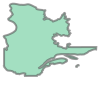

In [290]:
aoi = generate_polygon(canada_boundaries_endpoint, target_province)
aoi

In [291]:
blobs = container_client.list_blobs(name_starts_with=input_path)
raster_map = defaultdict(list)
for blob in blobs:
    if '.ipynb_checkpoints' in blob.name:
        container_client.delete_blob(blob)
        continue
    if blob.name.endswith('.png'):
        continue
    pth = Path(blob.name)
    map_key = '-'.join(pth.parts[3].split('-')[:2])
    raster_map[map_key].append(blob.name)
raster_map;

In [292]:
raster_month_map = {}
attr_copy = None
for k in raster_map.keys():
    _monthly_data = raster_map[k]
    # Open rasters into the dask cluster
    open_rasters = [
        rioxarray.open_rasterio(
            container_client.get_blob_client(_blob).url, chunks='auto')
        for _blob in _monthly_data]
    if attr_copy is None:
        attr_copy = open_rasters[0].attrs
        attr_copy['long_name'] = 'MODIS Snow Cover'
    month_data = xarray.concat(open_rasters, dim='band', combine_attrs='drop_conflicts')
    month_data = month_data.chunk('auto') # rechunk at dimension changes
    filtered_month_data = xarray.where(((month_data > 100)|(month_data == 0)), np.nan, month_data, keep_attrs=True)
    median_month_data = filtered_month_data.median(dim='band', skipna=True, keep_attrs=True)
    median_month_data = median_month_data.chunk('auto')
    raster_month_map[k] = median_month_data
ds = xarray.Dataset(data_vars=raster_month_map, attrs=attr_copy)
ds;

In [293]:
raster_map.keys()

dict_keys(['2009-10', '2009-11', '2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-10', '2010-11', '2010-12', '2011-10', '2011-11', '2011-12', '2017-10', '2017-11', '2017-12', '2021-01', '2021-02', '2021-03', '2021-04'])

In [298]:
seasonal_keys = defaultdict(list)
for k in raster_map.keys():
    year, month = k.split('-')
    if int(month) < 10:
        seasonal_keys[f'{int(year)-1}-{year}'].append(k)
    else:
        seasonal_keys[f'{year}-{int(year)+1}'].append(k)
seasonal_keys;

In [322]:
seasonal_map = defaultdict(list)
for k in seasonal_keys.keys():
    data_var_keys = seasonal_keys[k]
    for var in data_var_keys:
        seasonal_map[k].append(ds[var])

seasonal_map;

In [300]:
seasonal_map_arrays = {}
for k in seasonal_keys.keys():
    seasonal_map_arrays[k] = xarray.concat(seasonal_map[k], dim='season')
seasonal_map_arrays;

In [302]:
seasonal_medians = {}
for k in seasonal_keys.keys():
    seasonal_medians[k] = seasonal_map_arrays[k].median(dim='season', skipna=True, keep_attrs=True)
seasonal_median_ds = xarray.Dataset(data_vars=seasonal_medians)
seasonal_median_ds

<xarray.Dataset>
Dimensions:      (x: 3487, y: 3956)
Coordinates:
  * x            (x) float64 8.43e+05 8.435e+05 ... 2.458e+06 2.458e+06
  * y            (y) float64 1.643e+06 1.642e+06 ... -1.893e+05 -1.897e+05
    spatial_ref  int64 0
Data variables:
    2009-2010    (y, x) float64 dask.array<chunksize=(1648, 1453), meta=np.ndarray>
    2010-2011    (y, x) float64 dask.array<chunksize=(2518, 2220), meta=np.ndarray>
    2011-2012    (y, x) float64 dask.array<chunksize=(2518, 2220), meta=np.ndarray>
    2017-2018    (y, x) float64 dask.array<chunksize=(2518, 2220), meta=np.ndarray>
    2020-2021    (y, x) float64 dask.array<chunksize=(2181, 1922), meta=np.ndarray>

In [ ]:
seasonal_median_data_array = seasonal_median_ds.to_array(name='seasonal-median', dim='band')
season

In [303]:
seasonal_median = seasonal_median_ds.to_array(dim='band', name='seasonal-median').median(dim='band', skipna=True, keep_attrs=True).squeeze() 
seasonal_median

<xarray.DataArray 'seasonal-median' (y: 3956, x: 3487)>
dask.array<nanmedian, shape=(3956, 3487), dtype=float64, chunksize=(1952, 1718), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 8.43e+05 8.435e+05 ... 2.458e+06 2.458e+06
  * y            (y) float64 1.643e+06 1.642e+06 ... -1.893e+05 -1.897e+05
    spatial_ref  int64 0

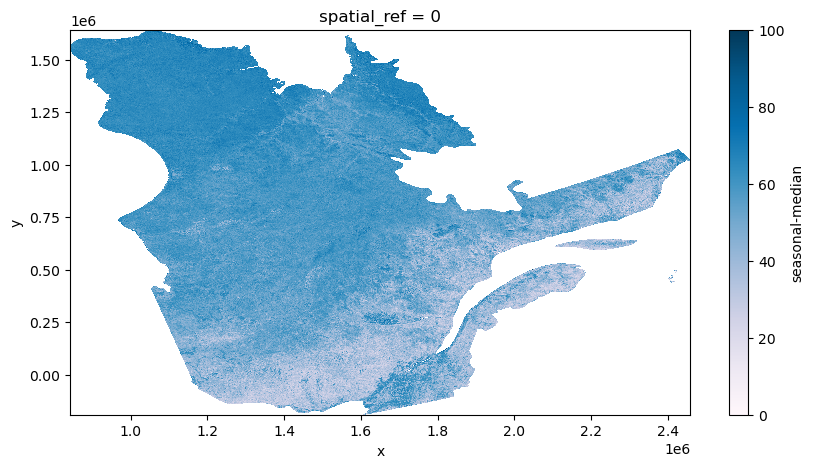

In [304]:
# Add title and description - large and in your face
seasonal_median.plot.imshow(figsize=(10,5), vmin=0, vmax=100, cmap='PuBu', clim=[0,100])

In [ ]:
# Save Seasonal Median Composites to Cloud Storage
write_delayeds = []
for key in seasonal_median_ds.keys():
    monthly_data_array = seasonal_median_ds[key]
    monthly_data_array.rio.write_crs(3978, inplace=True)
    output_path = Path('/'.join(input_path.split('/')[:2])).joinpath(
                    Path('snow-composites'),
                    Path(monthly_data_array.name)).as_posix() + '.tif'
    write_delayeds.append(write_raster(monthly_data_array, output_path, storage_creds))


# Include performance_report and memorysampler <<

print(dask.compute(write_delayeds))

### Insert Monthly Median Composites into GEOAnalytics Canada STAC Server



In [42]:
def create_stac_item(raster_path: str):
    stac_item = pystac.Item(
                    id=image_name,
                    href=f'https://stac.geoanalytics.ca/collections/Sentinel2_TEST/items/{image_name}',
                    geometry=mapping(geom),
                    bbox=FOOTPRINT.bounds,
                    datetime=time_acquired,
                    properties={}
    )

In [43]:
def create_or_update_stac_collection():

    collection = pystac.Collection(
                                    id='',
                                    href='https://stac.geoanalytics.ca/collections',
                                    title='',
                                    description='',
                                    extent='',
                                    keywords=[''],
                                    license='Proprietary',
                                  )
    collection.validate()

In [ ]:
auth_token = getpass("Please copy and paste your API Access Token here: ").strip()

In [ ]:
headers={'cookie': auth_token}
data = json.dumps(collection.to_dict())
# NOTE: on EO4PH, change the href base to https://stac.eo4ph.geoanalytics.ca/
r = requests.post('https://stac.geoanalytics.ca/collections/Sentinel2_TEST/', data=data, headers=headers)

In [ ]:
headers={'cookie': auth_token}
for index, stac_item in enumerate(local_stac_items):
    print(stac_item)
    data2 = json.dumps(stac_item.to_dict())
    # NOTE: on EO4PH, change the href base to https://stac.eo4ph.geoanalytics.ca/
    r = requests.post('https://stac.geoanalytics.ca/collections/Sentinel2_TEST/items', data=data2, headers=headers)
    print(r)

### Water Basin Analysis

In [180]:
result = requests.get('https://ftp.maps.canada.ca/pub/nrcan_rncan/vector/geobase_nhn_rhn/index/NHN_INDEX_WORKUNIT_LIMIT_2.zip')

<Response [200]>

In [181]:
try:
    os.makedirs('/tmp/nhn-index')
except FileExistsError:
    pass # Already exists
    
with zipfile.ZipFile(io.BytesIO(result.content), 'r') as zf:
        zf.extractall(path='/tmp/nhn-index')

In [185]:
shp_file = glob('/tmp/nhn-index/*.shp')[0]
gdf = gpd.read_file(shp_file)
df = gdf[gdf.intersects(aoi)]

In [191]:
target_basin = 'Lower Arnaud'

In [194]:
basin_df = df[df['WSCSSDANAM'] == target_basin].geometry
basin_df.explore()

In [195]:
basin_mp = MultiPolygon([poly for poly in basin_df.geometry.values.tolist() if isinstance(poly, Polygon)])
basin_mp

In [199]:
seasonal_median_arr = seasonal_median_ds.to_array(name=target_basin.replace(' ','').lower(), dim='band')
seasonal_median_arr.rio.write_crs(3978 , inplace=True)
seasonal_median_arr

<xarray.DataArray 'LowerArnaud' (band: 5, y: 3956, x: 3487)>
dask.array<stack, shape=(5, 3956, 3487), dtype=float64, chunksize=(1, 1648, 1453), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 8.43e+05 8.435e+05 ... 2.458e+06 2.458e+06
  * y            (y) float64 1.643e+06 1.642e+06 ... -1.893e+05 -1.897e+05
  * band         (band) object '2009-2010' '2010-2011' ... '2020-2021'
    spatial_ref  int64 0

In [200]:
basin_arr = seasonal_median_arr.rio.clip([basin_mp], crs=4326, all_touched=True)
basin_arr

<xarray.DataArray 'LowerArnaud' (band: 5, y: 659, x: 579)>
dask.array<getitem, shape=(5, 659, 579), dtype=float64, chunksize=(1, 659, 579), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 1.068e+06 1.068e+06 ... 1.335e+06 1.335e+06
  * y            (y) float64 1.548e+06 1.547e+06 ... 1.243e+06 1.243e+06
  * band         (band) object '2009-2010' '2010-2011' ... '2020-2021'
    spatial_ref  int64 0

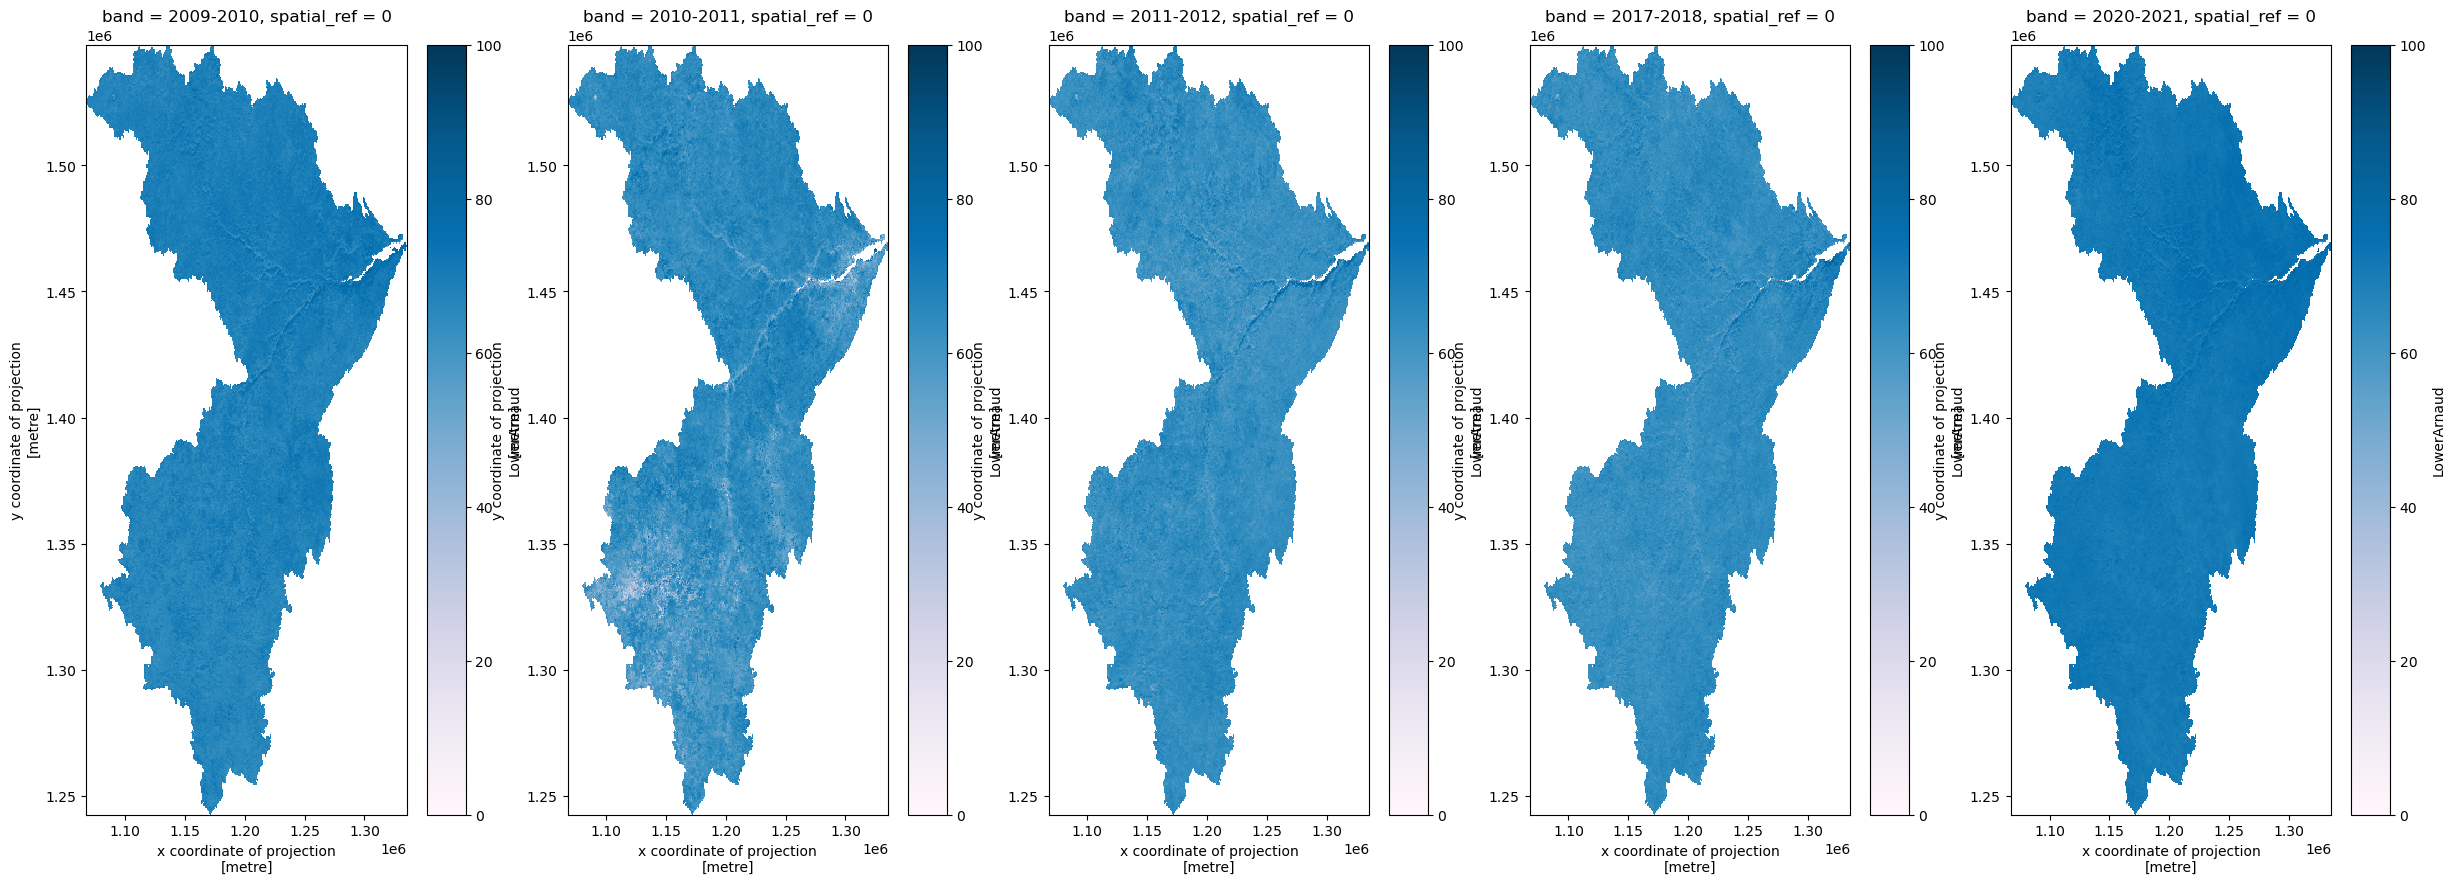

In [243]:
fig, ax = plt.subplots(1, basin_arr.shape[0], figsize=(30,10))
for i in range(basin_arr.shape[0]):
    basin_arr[i].plot.imshow(ax=ax[i], vmin=0, vmax=100, cmap='PuBu')
plt.show()